# AirFlow

**DAG:** Directed Acyclic Graph

    -Individual components does not loop

   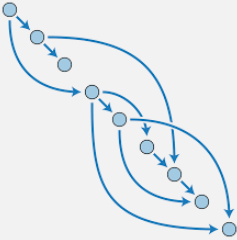

In [ ]:
#Import the Dag object
from airflow.models import Dag

from datetime import datetime

#attributes to be applied to our DAG (optional but powerfull)
default_arguments = {
    "owner": 'e-capi',
    'email': 'e-capi@owner.com', #e-mail for alerting
    "start_date": datetime(2021,1,20) #early datetime that the Dag can be run
}

#DAG Object
etl_dag = DAG('etl_workflow', default_args=default_arguments) #

**DAG's command line**

In [ ]:
airflow -h #Commands descriptions many related to DAG's
airflow list_dags #Shox all recognized DAG's

## Airflow Operators

**Represent a single task in a workflow, send and email, run a python script, run a command, etc.**

-They run independently and do not share information between operators

-Various operators to perform different tasks
    
        -DummyOperator(task_id='example', dag=dag)

In [ ]:
#Executes a given Bash command or script (requires 3 arguments; task_id, bash_command (raw command/script) & dag it belongs to.  
BashOperator(
         task_id='bash_example',
         bash_command='echo "Example!"',    (id script could be runcleanup.sh)
         dag=ml_dag)

In [ ]:
#BashOperator examples
from airflow.operators.bash_operator import BashOperator

example_task = BashOperator(task_id='bash_ex',
                           bash_command='echo 1',
                           dag=dag)

## Airflow Tasks

-Tasks are Instance of operators

-Usually assigned to a Python variable

### Task dependendencies

Define a given order of task completion

task dependencies are referred to as **upstream**(>>) or **downstream**(<<) tasks

**Upstream (before):** Most be completed prio to any *downstream* (after) task

In [ ]:
#Example:

task1 = BashOperator(task_id='first_task',
                           bash_command='echo 1',
                           dag=example_dag)

task2 = BashOperator(task_id='second_task',
                           bash_command='echo 2',
                           dag=example_dag)

#set first task to run before second task
task1 >> task2 # or task2 << task1

In [ ]:
#Mixed dependencies
task1>>task2<<task3
#or
task1>>task2
task3>>task2

## Additional operators

### PythonOperator

- Executes a Python function/callable

- Same as BashOperator but with more options

- Can pass arguments

In [ ]:
#Import
form airflow.operators.python_operator import PythonOperator

def printme():
    print('This goes in the logs!')
    
python_task = PythonOperator(
    task_id='simple_print',
    python_callable=printme,
    dag=example_dag
)

**Arguments:**

   - **Positional**
    
   - **Keyword:**  Use the op_kwargs dictionary

In [ ]:
#op_kwargs example
import time

def sleep(lenght_of_time):
    time.sleep(lenght_of_time)

sleep_task =PythonOperator(
    task_id='sleep',
    python_callable=sleep,
    op_kwargs={'lenght_of_time': 5},
    dag=example_dag
)

### Other Operators

Found in the *airflow.operators* library

Other examples are email operator which can contain html content or Attachments

In [ ]:
#Generate and email 
from airflow.operators.email_operator import EmailOperator

email_task = EmailOperator(
    task_id='email_sales_report',
    to='sales_manager@example.com',
    subject='Automated Sales Report',
    html_content='Attached is the latest sales report',
    files='latest_sales.xlsx',
    dag=example_dag
)

## Scheduling

A DAG runs: 
    
- A specific instance of a workflow at a point in time
- Can be run manually or via **schedule_interval**


**Schedule details**

- start_date: date/time to initially schedule the DAG run
- end_date: (optional) when to stop running DAG instances
- max_tries: (optional) attribute for how many attempts to make
- schedule_interval: How often to run (schedule for execution) 


**Schedule_interval:**

- How often to schedule the DAG
- Between the start_date and end_date (min and max value where the dag can run, not precise times)
- Scheduling can be defined via cron style syntax or via build-in presets

**Cron Syntax**

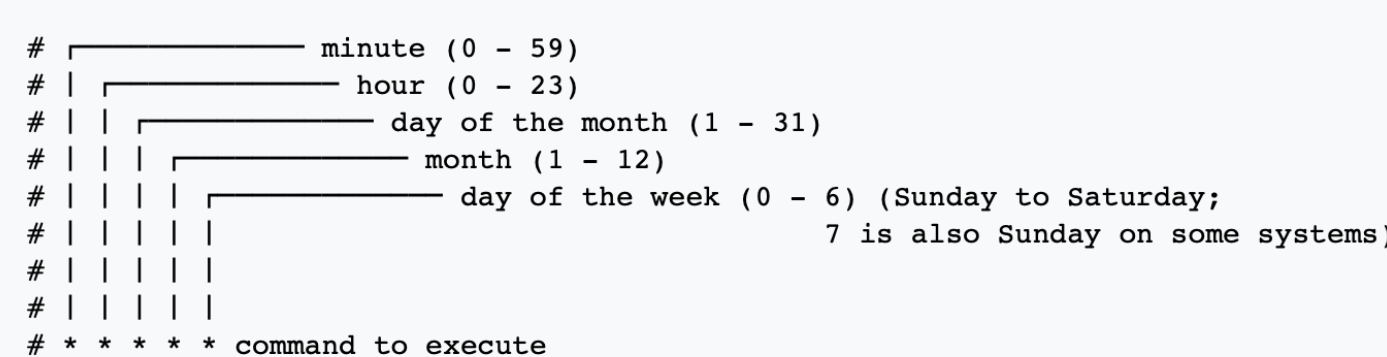

In [ ]:
0 12 * * * #Run daily at noon
* * 25 2 * #Run once per minute on February 25
0,15,30,45 * * * * #Run every 15 minutes

**Airflow scheduler presets**

**preset** -------------------------------- **cron equivalent**
- @hourly  -------------------------------- 0 * * * *
- @daily   -------------------------------- 0 0 * * *
- @weekly  -------------------------------- 0 0 * * 0



**cron * * * * * reference**

*minutes, *hours, *days, *months, *days of the week

**Special presets**

- **None**  - Don't schedule ever, used for manually triggered DAGs
- **@once** - Schedule only once

**/!\ Schedule_interal issues :**

- Use the *start_date* as the earliest possible value
- Schedule the task at start_date + schedule_interval


In [ ]:
'start_date': datetime(2020,2,25), #yyyy, m, d
'schedule_interval': @daily

    #This means the earliest starting time to run the DAG is on February 26th 2020

## Sensors

**Sensor is an operator that waits for a certain condition to be true**
- Creation of a file
- Upload of a database record
- Certain response from a web request

**Can define how often to check for the condition to be true**

**They are assign to tasks**


In [ ]:
#Import
from airflow.sensors.base_sensor_operator

**Sensor arguments:**

<code>**from** *airflow.sensors.base_sensor_operator*</code>

- <code>**mode**</code> - How to check for the condition
    - <code>**mode='poke'</code>** - The default, run repeatedly
    - <code>**mode='reschedule'**</code> - Give up task slot and try again later

- <code>**poke_interval**</code> - How often to wait between checks
- <code>**timeout**</code> - How long to wait (in seconds) before failing task (make sure is significantly shorter than schedule interval)

**File sensor:**

<code>**from** *airflow.contrib.sensors*</code> library

In [ ]:
#Example

from airflow.contrib.sensors.file_sensor import FileSensor

file_sensor_task = FileSensor(task_id="file_sense",
                              filepath='salesdata.csv',
                              poke_interval=300, #in seconds
                              dag=sales_report_dag)

#Task herarchy
init_sales_cleanup >> file_sensor_task >> generate_report

**Other sensors:**

- <code>**ExternalTaskSensor**</code> - wait for a task in another DAG to complete
- <code>**HttpSensor**</code> - Request a web URL and check for content
- <code>**SqlSensor**</code> - Runs a SQL query to check for content

Other sensors in **airflow.sensors** and **airflow.contrib.sensors** 

## Executors

**Executors:**

- Run tasks
- Different executors handle running tasks differently (run single a single task on local / split individual tasks among all the system as a cluster


- Executors Examples:
    - <code>**SequentialExecutor**</code>:
        - Default Airflow executor
        - Runs one task at a time
        - Useful for debugging
        - While functional, **not** really recommended for production
    - <code>**LocalExecutor**</code>
        - Runs on a single system
        - Treats tasks as a processes
        - *Parallelism* defined by the user (unlimited or limited to a certain number of simultaneous tasks)
        - Can utilize all resources of a given host system (Good choice for a single production Airflow system)
    - <code>**CeleryExecutor**</code>
        - Uses a Celery backend as a task manager (Python queueing system that allows multiple system to communicate as a basic cluster
        - Multiple worker systems can be defined (multiple Airflow systems can be configured as workers for a given setup or task)
        - Is significantly more difficult to setup & configure
        - Extremely powerful method for organizations with extensive workloads

**Determine your executor**
- Command line via <code>airflow.cfg</code> file
- Look for the **executor=** line 
    - <code>cat airflow/airflow.cfg | grep "executor ="
    executor = SequentialExecutor</code>
    
**Determine your executor #2**
- Via the first line of <code>airflow list_dags</code> *command line*
    - INFO - Using <code>SequentialExecutor</code> 

## Debugging and troubleshooting in Airflow

**Typical issues...**
- **DAG won't run on schedule:**
    - Check if scheduler is running
        - **<ins>fix</ins>:** <code>airflow scheduler</code> *from command-line*
        
    - At least one <code>schedule_interval</code> hasn't passed.
        - **<ins>fix</ins>:** Modify the attributes to meet your requirements. (no specific fix)
        
    - Not enough tasks free within the executor to run.
        - **<ins>fixes</ins>:**
            - Change executor type
            - Add system resources
            - Add more systems
            - Change DAG scheduling
- **Dag won't load:**
    - DAG not in web UI
    - DAG not in <code>airflow list_dags</code>
    - **<ins>Possible solutions</ins>:**
        - Verify DAG file is in correct folder
        - Determine the DAGs folder via <code>airflow.cfg</code>
        
            - ~$ head airflow/airflof.cfg
            - <code>dags_folder = /home/repl/airflow/dags</code> (must be an absolute path)

- **Syntax errors:**
    - **<ins>Possible solutions</ins>:**
        - Run <code>airflow list_dags</code>
            - Will give debugging info on the command line
        - Run <code>python3 dagfile.py </code>
            - If they are errors -> a Traceback will appeared

## SLAs and reporting

**SLA:** *(Service Level Agreement)*
- The amount of time a task or a DAG should require to run
- *SLA Miss* is any time the task / DAG does not meet the expected timing
- If an SLA is missed, an email is sent out and a log is stored.
- You can view SLA missed in the web UI

**SLA Misses:**
- Found under Browser: SLA Misses
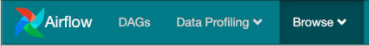

**Defining SLAs:**

- Using the <code>'sla'</code> argument on the task

In [ ]:
task1 = BashOperator(task_id='sla_task',
                    bash_commad='runcode.sh',
                    sla=timedelta(seconds=30),
                    dag=dag)

- On the <code>default_args</code> dictionary

In [ ]:
default_args={
    'sla': timedelta(minutes=20),
    'start_date': datetime(2020,2,20)
}
dag = DAG('sla_dag', default_args=default_args)

**timedelta object:**
- In the <code>datetime</code> library
- Accessed via <code>from datetime import timedelta</code>
- Takes arguments; days, seconds, minutes, hours and weeks

    <code>timedelta(days=4, hours=10, minutes=20, seconds=30)</code>

**General reporting:**
- Options for success / failure/ error (sending messages options)
- Keys in the default_args discionary

In [ ]:
default_args = {
    'email': 'airflowalerts@owner.com',
    'email_on_failure': True,
    'email_on_retry': False,
    'email_on_success': True,
}

- Within DAGs from <code>EmailOperator</code> *(Global email on the Airflow documentation)*

## Working with templates

**Templates:**
- Allow substituting information during a DAG run
- Provide added flexibility when defining tasks
- Templates are created using the <code>Jinja</code> templating language

**Non-Templated BashOperator example:**
- Create a task to echo a list of files **(DRY)**

In [ ]:
#Templated BashOperator example:
template_command = """
    echo "Reading {{params.filename}}" 
    """
#Create airflow task
t1 = BashOperator(task_id ='template_task',
                 params={'filename': 'file.txt'},
                 dag=example_dag)

In [ ]:
#Templated BashOperator example continue:
template_command = """
    echo "Reading {{params.filename}}" 
    """
#Create airflow task
t1 = BashOperator(task_id ='template_task',
                 params={'filename': 'file.txt'},
                 dag=example_dag)

t2 = BashOperator(task_id ='template_task',
                 params={'filename': 'file2.txt'},
                 dag=example_dag)

In [ ]:
#datetime example
cleandata_dag = DAG('cleandata',
                    default_args=default_args,
                    schedule_interval='@daily')

# Create a templated command to execute
# 'bash cleandata.sh datestring'
templated_command="""
bash cleandata.sh {{ ds_nodash }}""" 


# Modify clean_task to use the templated command
clean_task = BashOperator(task_id='cleandata_task',
                          bash_command=templated_command,
                          dag=cleandata_dag)


In [ ]:
#example
from airflow.models import DAG
from airflow.operators.bash_operator import BashOperator
from datetime import datetime

default_args = {
  'start_date': datetime(2020, 4, 15),
}

cleandata_dag = DAG('cleandata',
                    default_args=default_args,
                    schedule_interval='@daily')

# Modify the templated command to handle a
# second argument called filename.
templated_command = """
  bash cleandata.sh {{ ds_nodash }} {{params.filename}}
"""

# Modify clean_task to pass the new argument
clean_task = BashOperator(task_id='cleandata_task',
                          bash_command=templated_command,
                          params={'filename': 'salesdata.txt'},
                          dag=cleandata_dag)

# Create a new BashOperator clean_task2
clean_task2 = BashOperator(task_id='cleandata_task2',
                           bash_command=templated_command,
                           params={'filename': 'supportdata.txt'},
                           dag=cleandata_dag)
                           
# Set the operator dependencies
clean_task >> clean_task2

### More templates

**More advance templates:**

In [ ]:
template_command="""
{% for filename in params.filenames %}
    echo "Reading{{filename}}"
{% endfor %}
""" #{% endfor %} it's a Jinja entry representing the end of the for loop

t1 = BashOperator(task1='template_task',
                 bash_command= template_command,
                 params={'filename': ['file1.txt', 'file2.txt']} #<- maybe creating a function for creating n file names 
                 dag=example_dag)

**Variables:**
- Airflow built-in runtime variables
- Provides assorted information about DAG runs, and even the system configuration
- **Examples Include:** *(String not **Datetime** python object)*
    - Execution Date: <code>{{ ds }} </code> *# YYYY-MM-DD*
    - Execution Date, no dashes: <code>{{ ds_nodash }}</code> *# YYYYMMDD*
    - Prev Execution date: <code>{{ prev_ds }}</code> *# YYYY-MM-DD*
    - Prev Execution date, no dashes: <code>{{ prev_ds_nodash }}</code> *# YYYYMMDD*
    - DAG **<ins>object</ins>:** <code>{{ dag }}</code>
    - Airflow config object: <code>{{ conf }}</code>

**Macros:**

<code>{{ macros }}</code> variable
- <code>{{ macros.datetime }}</code>: The <code>datetime.datetime</code> object
- <code>{{ macros.timedelta }}</code>: The <code>timedelta</code> object
- <code>{{ macros.uuid }}</code>: Python's <code>uuid</code> object
- <code>{{ macros.ds_add('2020-04-15', 5) }}</code>: Modify days from a date, this example **returns *2020-04-20*** (can subtract if **int** is negative)


**Exercise instructions:**
- Create a Python string that represents the email content you wish to send. Use the substitutions for the current date string (with dashes) and a variable called <code>username</code>.

- Create the <code>EmailOperator</code> task using the template string for the html_content.

- Set the subject field to a macro call using <code>macros.uuid.uuid4()</code>. This simply provides a string of a universally unique identifier as the subject field.

- Assign the <code>params</code> dictionary as appropriate with the <code>username</code> of <code>testemailuser</code>.

In [ ]:
#Example
from airflow.models import DAG
from airflow.operators.email_operator import EmailOperator
from datetime import datetime

# Create the string representing the html email content
html_email_str = """
Date: {{ ds }} #date with dashes
Username: {{ params.username }} #call the params username
"""

email_dag = DAG('template_email_test',
                default_args={'start_date': datetime(2020, 4, 15)},
                schedule_interval='@weekly')
                
email_task = EmailOperator(task_id='email_task',
                           to='testuser@datacamp.com',
                           subject="{{ macros.uuid.uuid4() }}", #generate a s universally unique subject field
                           html_content=html_email_str, #call the template
                           params={'username': 'testemailuser'},
                           dag=email_dag)

## Branching

**Branching in Airflow:**
- Provides condition logic
- Using <code>BranchPythonOperator</code>
- <code>from airflow.operators.python_operator import BranchPythonOperator</code>
- Takes a <code>python_callable</code> to return the next task id (or list of ids) to follow

In [ ]:
#Branching Example

def branch_test(**kwargs):
    if int(kwargs['ds_nodash']) % 2 ==0:
        return 'even_day_task'
    else:
        return 'odd_day_task'
    
    
branch_task = BranchPytythonOperator(task_id='branch_test',
                                     dag=dag,
                                    provide_context=True,
                                    python_callable=branch_test)

start_task>> branch_task >> even_day_task >>even_day_task2
branch_task >> odd_day_task >> odd_day_task2

**Branching example2:**

You'd like to run a different code path if the current execution date represents a new year (ie, 2020 vs 2019).
The DAG is defined for you, along with the tasks in question. Your current task is to implement the BranchPythonOperator.

**Instructions:**
- In the function <code>year_check</code>, configure the code to determine if the year of the current execution date is different than the previous execution date (ie, is the year different between the appropriate Airflow template variables.)
- Finish the <code>BranchPythonOperator</code> by adding the appropriate arguments.
- Set the dependencies on <code>current_year_task</code> <code>and new_year_task</code>.

In [ ]:
# Create a function to determine if years are different
def year_check(**kwargs):
    current_year = int(kwargs['ds_nodash'][0:4])
    previous_year = int(kwargs['prev_ds_nodash'][0:4]) #prev_ds_nodash gives the previous year
    if current_year == previous_year:
        return 'current_year_task'
    else:
        return 'new_year_task'

# Define the BranchPythonOperator
branch_task = BranchPythonOperator(task_id='branch_task', dag=branch_dag,
                                   python_callable=year_check, provide_context=True) #call the function and set context to true
# Define the dependencies
branch_dag >> current_year_task
branch_dag >> new_year_task

## Creating Production Pipelines

**Reminder to run a specific task from command line:**

<code>airflow run dag_id task_id date </code>

**To run a full DAG:**

<code>airflow trigger_dag -e date dag_id </code>

**Operators reminder:**

- **BashOperator** - expects <code>bash_command</code>
- **PythonOperator** - expects a <code>python_callable</code>
- **BranchPythonOperator** - requires a <code>python_callable</code> and <code>provide_context=True</code>. The callable must accept <code>**kwargs</code>. 
- **Filesensor** - requires <code>filepath</code> arguments and might need <code>mode</code> or <code>poke_interval</code> attributes

**Template reminders:**
- Many objects in Airflow can use templates
- certain fields may use templated string, while others do not
- One way to check is to use build-in documentation:
    - Open python3 interpreter
    - import necessary libraries(ie, <code>from airflow.operators.bash_operator import BashOperator</code>
    - At prompt, run <code>help (Airflow object)</code>, ie, help(BashOperator)
    - Look for a line that referencing *template_fields*. This will specify any of the arguments that can use templates

**Test a task:**

<code>airflow test *dag_id* *task_id* *date*</code>

## Last Exercise

**Adding the final changes to your pipeline**

To finish up your workflow, your manager asks that you add a conditional logic check to send a sales report via email, only if the day is a weekday. Otherwise, no email should be sent. In addition, the email task should be templated to include the date and a project name in the content.

The branch callable is already defined for you.

**Instructions**

- Import the necessary operators.
- Configure the EmailOperator to provide the specific data to the callable.
- Complete the branch callable as necessary to point to the <code>email_report_task</code> or <code>no_email_task</code>.
- Configure the branch operator to properly check for the condition.

In [ ]:
#Otherfile
from datetime import date

def process_data(**kwargs):
    file = open("/home/repl/workspace/processed_data-" + kwargs['ds'] + ".tmp", "w")
    file.write(f"Data processed on {date.today()}")
    file.close()

In [ ]:
from airflow.models import DAG
from airflow.contrib.sensors.file_sensor import FileSensor
from airflow.operators.bash_operator import BashOperator
from airflow.operators.python_operator import PythonOperator
from airflow.operators.python_operator import BranchPythonOperator
from airflow.operators.dummy_operator import DummyOperator
from airflow.operators.email_operator import EmailOperator
from dags.process import process_data
from datetime import datetime, timedelta

# Update the default arguments and apply them to the DAG.

default_args = {
  'start_date': datetime(2019,1,1),
  'sla': timedelta(minutes=90)
}
    
dag = DAG(dag_id='etl_update', default_args=default_args)

sensor = FileSensor(task_id='sense_file', 
                    filepath='/home/repl/workspace/startprocess.txt',
                    poke_interval=45,
                    dag=dag)

bash_task = BashOperator(task_id='cleanup_tempfiles', 
                         bash_command='rm -f /home/repl/*.tmp',
                         dag=dag)

python_task = PythonOperator(task_id='run_processing', 
                             python_callable=process_data, #Import from process.py
                             provide_context=True,
                             dag=dag)


email_subject="""
  Email report for {{ params.department }} on {{ ds_nodash }}
"""


email_report_task = EmailOperator(task_id='email_report_task',
                                  to='sales@mycompany.com',
                                  subject=email_subject,
                                  html_content='',
                                  params={'department': 'Data subscription services'},
                                  dag=dag)


no_email_task = DummyOperator(task_id='no_email_task', dag=dag)


def check_weekend(**kwargs):
    dt = datetime.strptime(kwargs['execution_date'],"%Y-%m-%d")
    # If dt.weekday() is 0-4, it's Monday - Friday. If 5 or 6, it's Sat / Sun.
    if (dt.weekday() < 5):
        return 'email_report_task'
    else:
        return 'no_email_task'
    
    
branch_task = BranchPythonOperator(task_id='check_if_weekend',
                                   provide_context=True,
                                   python_callable=check_weekend,
                                   dag=dag)

    
sensor >> bash_task >> python_task

python_task >> branch_task >> [email_report_task, no_email_task]


## Create an Airflow env and setting up a Pipeline

In [ ]:
pip install virtualenv
virtualenv airflow-venv

In [ ]:
find ~/ -name "airflow"